# Regularization

## Out-of-Sample Performance

We will look to the semiconductor.csv dataset, a collection of 1500 observations with each observation being a vector of 200 signals, to better understand a model that over-fits. We will first look to predict the failyre of a semiconductor.

In [1]:
#Set the working directory to the specific location of the files on your computer
#note: In this case, the working directory was set for my computer
setwd("/Users/Brandon/Harding_ML_Class")

#set graphical parameters (this is only needed for jupyter notebooks)
options(repr.plot.width = 10, repr.plot.height = 5)

In [2]:
#Import the data file semiconductor.csv into R
SC <- read.csv("semiconductor.csv")

In [3]:
#Fit the full model
full <- glm(FAIL ~ ., data=SC, family=binomial)

#Calculate the R-squared statistic
1 - full$deviance/full$null.deviance

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] 0.5621432

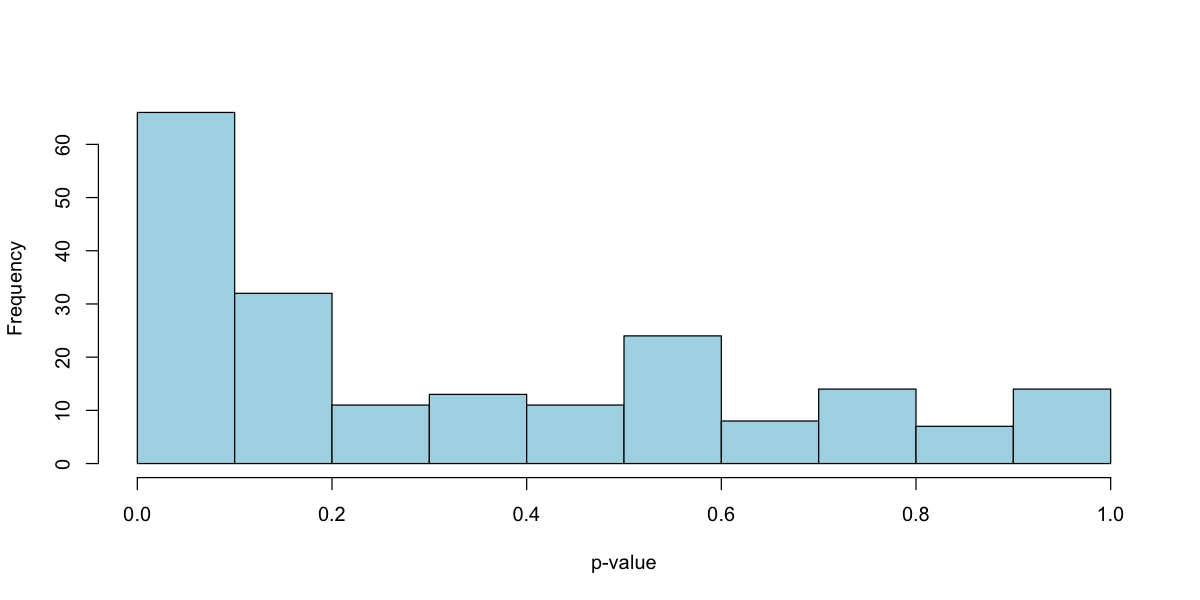

In [4]:
##Since roughly 56% of the variation is explained by the 200 signals, let's view a plot of the signal (predictor) p-values

#Grab p-values
pvals <- summary(full)$coef[-1,4] #-1 to drop the intercept

#Plot them: it looks like we have some signal here
hist(pvals, xlab="p-value", main="", col="lightblue")

### We seea spike in the p-values in the 0 bin of the histogram above. TRhus, we can use the BH FDR algorithm to reduce the quantity of predictors to use in our model. We will perform the BH FDR algorithm to achieve an FDR of no more than 10%.

[1] 0.01217043

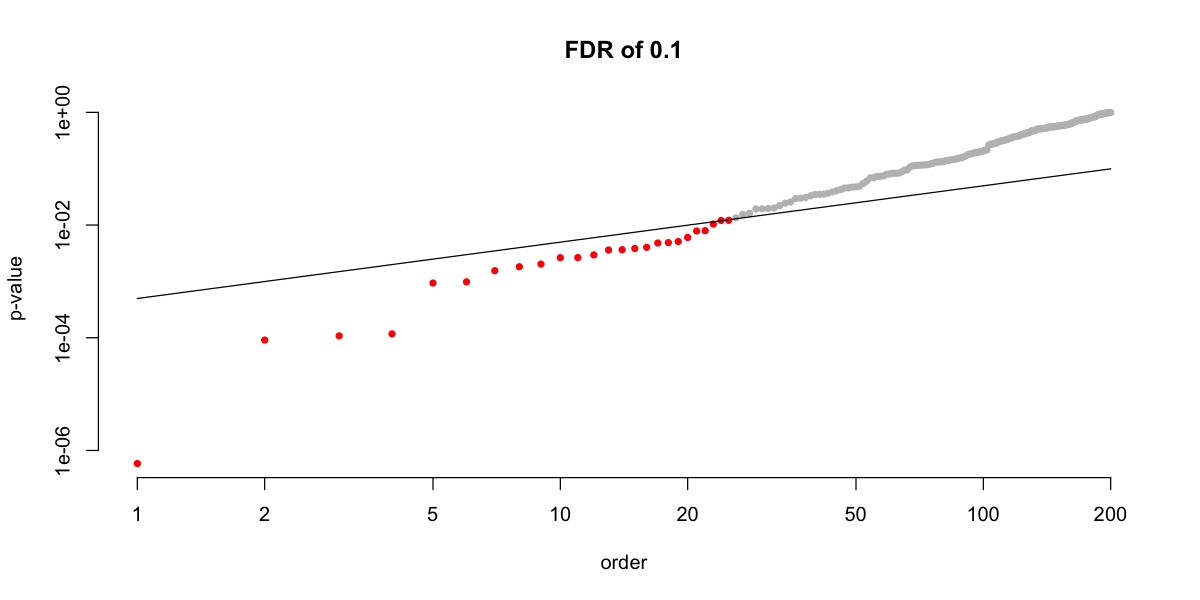

In [5]:
## At 10% FDR, we get 25 `signif'

#define new function to perform the BH FDR algorithm
fdr_cut <- function(pvals, q=0.1){
    #Sort p-values from least to greatest
    pvals <- sort(pvals[!is.na(pvals)])
    #Get the number of p-values to consider
    N <- length(pvals)
    #Returns the p-values index position in the pvals (vector) [recall the formula for BH FDR is (q/n)(k)]
    k <- rank(pvals, ties.method="min")
    #Calculate the alpha cutoff for the last p-value accepted as significant
    alpha <- max(pvals[ pvals<= (q*k/(N+1)) ])
    
    #Plot the p-values and mark those significant in specified FDR of 10% as significant
    plot(pvals, log="xy", xlab="order", main=sprintf("FDR of %g",q),
         ylab="p-value", bty="n", col=c(8,2)[(pvals<=alpha) + 1], pch=20)
    #Add line of significance to plot
    lines(1:N, q*(1:N)/(N+1))
    
    return(alpha)
}

fdr_cut(pvals)

In [6]:
## Re-run a cut regression using only these 25 significant variables

#Identify significant variables (we have rounded alpha from above to 0.0122)
signif <- which(pvals <= 0.0122)

#Perform regression with only the identified significant variables
cut <- glm(FAIL ~ ., data=SC[,c("FAIL", names(signif))], family="binomial")

#Calculate the new R-squared statistic (this is the output below)
1 - cut$deviance/cut$null.deviance # new in-sample R2

[1] 0.1811822

## K-Fold Out-of-Sample (OOS) Validation

### From above, the removal of variables from the model hurt the R-squared statistic. This provides excellent justification about why we usually disregard the R-squared vaue to measure the value of a model in-sample. Our real concern is how well our model predicts on new data. In this way, we can use the K-fold cross validation algorithm to mimic our model predictive ability on unseen data.

### We will now walk through performing OOS Validation on the semiconductor full and reduced models.

In [7]:
##First, we need to define functions to calculate deviance and R-squared

#For deviance (note: pred must be probabilities (0<pred<1) for binomial)
#For review of deviance calculations, see pg.60 of textbook
deviance <- function(y, pred, family=c("gaussian","binomial")){
    family <- match.arg(family)
    if(family=="gaussian"){
        return( sum( (y-pred)^2 ) )
    }else{
        if(is.factor(y)) y <- as.numeric(y)>1
        return( -2*sum( y*log(pred) + (1-y)*log(1-pred) ) )
    }
}

## Calculate R-squared by using deviance function above
R2 <- function(y, pred, family=c("gaussian","binomial")){
    fam <- match.arg(family)
    if(fam=="binomial"){
        if(is.factor(y)){ y <- as.numeric(y)>1 }
    }
    #Calculate residual deviance
    dev <- deviance(y, pred, family=fam)
    #Calculate null deviance
    dev0 <- deviance(y, mean(y), family=fam)
    #Calculate R-squared value
    r_2 <- 1-dev/dev0
    return(r_2)
}

In [8]:
##Partition data into K-folds (note: here we will be using 10 folds

#The number of observations
n <- nrow(SC) 

#The number of `folds'
K <- 10

#Create a vector of fold memberships (random order)
# note: This essentially creates a random order of the n observation indexes and assigns each a fold.
#       An easy way to think of foldid vector is that the fold number in the first position
#       corresponds to the fold observation to which one belongs.
foldid <- rep(1:K,each=ceiling(n/K))[sample(1:n)]
#the head of foldid is shown in the output below
head(foldid)

#Create an empty dataframe of results
OOS <- data.frame(full=rep(NA,K), cut=rep(NA,K)) 

[1] 7 7 7 5 2 9

In [9]:
#Recall the names of the variables that are a part of the 25 significant
cutvar <- names(signif)

In [10]:
#Use a for-loop to run OOS (aka K-Fold Cross Validation)
for(k in 1:K){ 
    train <- which(foldid!=k) # train on all but fold `k'

    #Fit the two regressions
    rfull <- glm(FAIL ~ ., data=SC, subset=train, family=binomial)
    rcut <- glm(FAIL ~ ., data=SC[,c("FAIL",cutvar)], subset=train, family=binomial)

    #Get predictions: type=response so we have probabilities
    predfull <- predict(rfull, newdata=SC[-train,], type="response")
    predcut <- predict(rcut, newdata=SC[-train,], type="response")

    #Calculate and log R-squared metric
    OOS$full[k] <- R2(y=SC$FAIL[-train], pred=predfull, family="binomial")
    OOS$cut[k] <- R2(y=SC$FAIL[-train], pred=predcut, family="binomial")

    ## print progress
    cat(k, " ")
}

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

1  

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

2  

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

3  

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

4  

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

5  

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

6  

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

7  

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

8  

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

9  

Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

10  

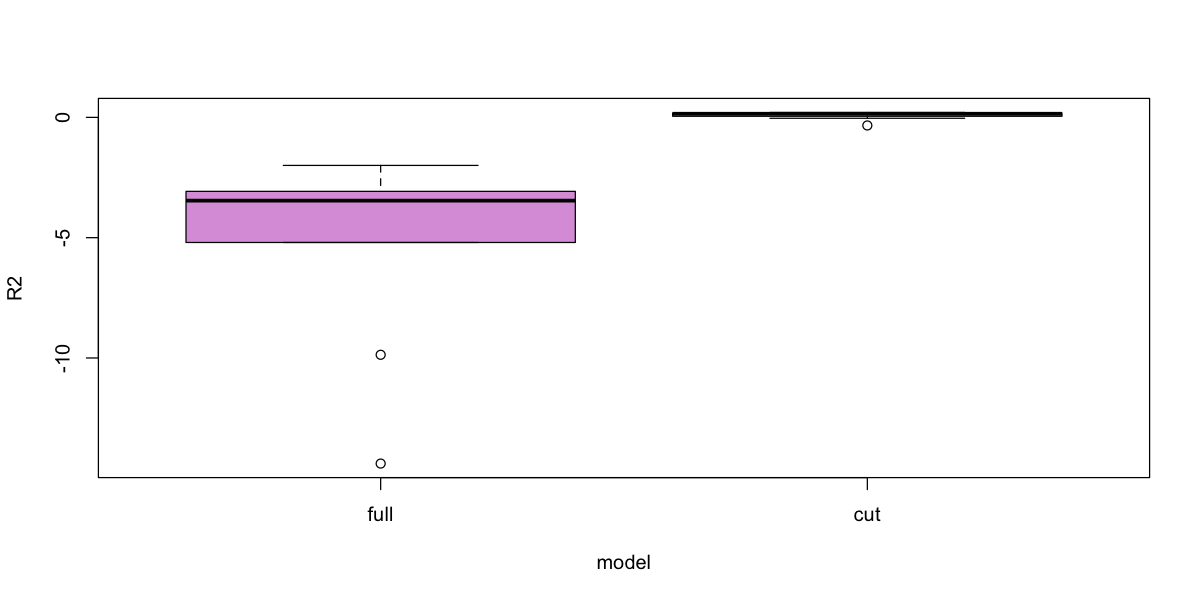

In [11]:
#Plot the R-squared values for the full and cut models
boxplot(OOS, col="plum", ylab="R2", xlab="model", bty="n")

#NOTE: negative R-squared values are common when looking at out of sample model performance

# Regularization Paths

## Forward Stepwise Regression

The forward stepwise regression algorithm to choose the ideal predictors to include in a model looks to begin with a simple model and progressively add predictors.

In [12]:
##A forward stepwise procedure

#Define a null model
null <- glm(FAIL~1, data=SC)

#Perform forward stepwise model selection (note: it takes a long time!)
#note: R's step function is a greedy approach using the AIC metric for model predictive performance
fwd <- step(null, scope=formula(full), dir="forward")

#View number of coefficients in final model
length(coef(fwd)) #Its around 70

Start:  AIC=115.03
FAIL ~ 1

         Df Deviance     AIC
+ SIG2    1   91.699  92.588
+ SIG189  1   92.132  99.534
+ SIG13   1   92.327 102.664
+ SIG166  1   92.406 103.923
+ SIG61   1   92.463 104.832
+ SIG173  1   92.588 106.832
+ SIG50   1   92.619 107.323
+ SIG167  1   92.743 109.302
+ SIG24   1   92.793 110.103
+ SIG18   1   92.813 110.419
+ SIG154  1   92.830 110.685
+ SIG178  1   92.893 111.690
+ SIG57   1   92.897 111.761
+ SIG136  1   92.918 112.094
+ SIG7    1   92.934 112.344
+ SIG117  1   92.934 112.345
+ SIG147  1   92.937 112.387
+ SIG104  1   92.948 112.564
+ SIG153  1   92.971 112.926
+ SIG193  1   92.973 112.959
+ SIG97   1   92.977 113.029
+ SIG99   1   92.978 113.042
+ SIG42   1   92.983 113.125
+ SIG175  1   92.994 113.293
+ SIG142  1   92.997 113.347
+ SIG133  1   92.998 113.360
+ SIG155  1   93.016 113.644
+ SIG111  1   93.022 113.735
+ SIG169  1   93.023 113.762
+ SIG134  1   93.030 113.867
+ SIG16   1   93.036 113.968
+ SIG27   1   93.037 113.971
+ SIG80   1   

[1] 69

## LASSO: Least Absolute Shrinkage and Selection Operator

The following code will walk through performing lasso in R.

In [13]:
#Use the glmnet library (note: gamlr was not compatible with anaconda)
library("glmnet")

#Use Matrix package to create sparse model matrix
library("Matrix")

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16



In [14]:
# For gamlr, and most other functions, you need to create your own numeric
# design matrix.  We'll do this as a sparse `simple triplet matrix' using 
# the sparse.model.matrix function.
# here, we could have also just done x <- as.matrix(SC[,-1]).
# but sparse.model.matrix is a good way of doing things if you have factors.
scx <- sparse.model.matrix(FAIL ~ ., data=SC)[,-1] # do -1 to drop intercept!

# pull out `y' too just for convenience
scy <- SC$FAIL 

In [15]:
#Fit a single lasso
sclasso <- glmnet(scx, scy, family="binomial", lambda.min.ratio=0.01)

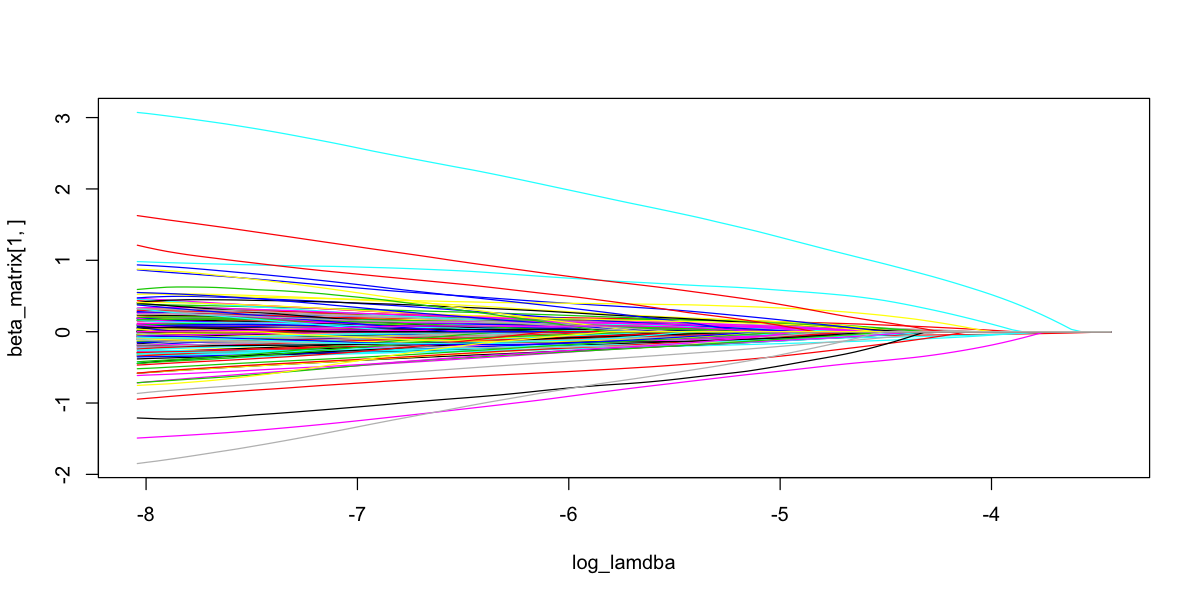

In [16]:
#### To plot the path of the coefficients...

### For the gamlr package, it is as simple as 
# plot(sclasso)

###For the glmnet package...

# plot(sclasso) will yield a plot of coefficients with respect to different lambdas
# yet this plot will differ from what is seen in the textbook

##Since we used glmnet and to get a better understanding of the path plot, we will construct it ourselves

#First, pull the lambda values used from the lasso regression object and log transform them
log_lamdba <- log(sclasso$lambda)

#Second, pull the coefficient matrix from the lasso regression object
#Note: it is easier to work with a simple matrix rather than a sparse matrix for plotting purposes
beta_matrix <- as.matrix(sclasso$beta)

#note: that the beta_matrix works as follows each row is an individual coefficient
# and each column is the coefficent under a specific lambda
#(column one is greatest lambda and lambda decreases as you move toward the right-most column)

#Third, pull the number of coefficients which is the number of rows of the beta_matrix
num_coefs <- nrow(beta_matrix)

##Construct plot
#Plot first coefficient and establish plot
plot(x = log_lamdba,y = beta_matrix[1,],type="l",col=100,
     ylim=c(min(beta_matrix),max(beta_matrix)) #want y-axis to reach as far as the greatest coefficient and least coefficient
    )
#Plot each additional coefficient
for(i in 2:num_coefs){
  points(log_lamdba,beta_matrix[i,],type="l",col=i)
}

### Sidenote about Sparse Matricies

Recall the oj dataset used to introduce the concept of regression without regularization. When we were constructing our model matrix, we used a reference level for the brand factor column to avoid multicollinearity (remeber there were three brands: Dominick's, Minute.maid, and Tropicana). This meant that a dummy column for Dominick's was excluded from the model matrix. When performing regression with regularization such as lasso, we can safely drop the use of the reference level such that lasso will push the brand coefficients down to a shared intercept.

In [17]:
#Import the data file oj into R
oj <- read.csv("oj.csv")

In [18]:
#Creation of model matrix for regression without regularization
X <- model.matrix( ~ log(price) + brand #use right hand side of the regression to specify how to fill matrix
                  ,data=oj #specify data to fill matrix
                 )
#View X
head(X)
#Note: the brand Dominick's was established as the reference level and was thus excluded from the model matrix

,(Intercept),log(price),brandminute.maid,brandtropicana
1,1,1.353255,0,1
2,1,1.353255,0,1
3,1,1.353255,0,1
4,1,1.353255,0,1
5,1,1.353255,0,1
6,1,1.353255,0,1


In [19]:
###Creation of model matrix for regression WITH regularization

##First, create useful functions

#Create function to change a factor columns categories to set NA as the reference level
xnaref <- function(x){
    if(is.factor(x))
        if(!is.na(levels(x)[1]))
            x <- factor(x,levels=c(NA,levels(x)),exclude=NULL)
    return(x) }

#Create function to apply the xnaref function above ot a data frame
naref <- function(DF){
    #Return data frame if empty
    if(is.null(dim(DF))) return(xnaref(DF))
    #Return error if no data frame is supplied
    if(!is.data.frame(DF)) 
        stop("You need to give me a data.frame or a factor")
    #With a good data frame supplied, apply xnaref to all factor columns
    DF <- lapply(DF, xnaref)
    #Return the data frame with NA reference level factor columns
    return(as.data.frame(DF))
}

##Apply above functions to oj
oj$brand <- naref(oj$brand)

##Create sparse matrix
xbrand <- sparse.model.matrix( ~ brand, data=oj)
#View sparse model matrix
xbrand[c(100,200,300),]


3 x 4 sparse Matrix of class "dgCMatrix"
    (Intercept) branddominicks brandminute.maid brandtropicana
100           1              .                .              1
200           1              .                1              .
300           1              1                .              .

# Model Selection

## K-Fold Cross Validation with LASSO

We will now use cross validation with a regression that incorporates lasso regularization. We will use a different web browsing dataset that describes computers browsing history and money spent at websites.

In [20]:
## The table has three colums: [machine] id, site [id], [# of] visits
web <- read.csv("browser-domains.csv")

In [21]:
#View data structure
str(web)

'data.frame':	2271684 obs. of  3 variables:
 $ id    : int  991 7940 2453 1650 1290 378 4678 4867 1538 2724 ...
 $ site  : int  873 873 873 873 873 873 873 873 873 873 ...
 $ visits: int  1 2 12 1 6 55 1 2 35 7 ...


In [22]:
## Read in the actual website names and relabel site factor
sitenames <- scan("browser-sites.txt", what="character")
web$site <- factor(web$site, levels=1:length(sitenames), labels=sitenames)

In [23]:
## also factor machine id
web$id <- factor(web$id, levels=1:length(unique(web$id)))

In [24]:
## get total visits per-machine and % of time on each site
## tapply(a,b,c) does c(a) for every level of factor b.
machinetotals <- as.vector(tapply(web$visits,web$id,sum)) 
visitpercent <- 100*web$visits/machinetotals[web$id]

In [25]:
#View the new structure of the web dataset
str(web)

'data.frame':	2271684 obs. of  3 variables:
 $ id    : Factor w/ 10000 levels "1","2","3","4",..: 991 7940 2453 1650 1290 378 4678 4867 1538 2724 ...
 $ site  : Factor w/ 1000 levels "atdmt.com","yahoo.com",..: 873 873 873 873 873 873 873 873 873 873 ...
 $ visits: int  1 2 12 1 6 55 1 2 35 7 ...


Now we need to create a sparse matrix for modeling. Recall that a sparse matrix provides an efficient way to store data with lots of zeros. If we think in terms of a regular matrix, we want to store the amount of time spent by a particular machine at a partiuclar site. Thus, if we are constructing this regular matrix, our row axis (i axis) describes a particular machine and the column axis (j axis) describes a particular website. So, item i,j in this regular matrix describes the amount of time spent by machine i at website j. Creating a sparse matrix of this is simply, transferring this description into the sparse matrix code. We show that now.

In [26]:
##Use this info in a sparse matrix
xweb <- sparseMatrix(
    i=as.numeric(web$id), j=as.numeric(web$site), x=visitpercent,
    dims=c(nlevels(web$id),nlevels(web$site)),
    dimnames=list(id=levels(web$id), site=levels(web$site)))

In [27]:
#For example, what sites did household 1 visit?
head(xweb[1, xweb[1,]!=0])

atdmt.com          yahoo.com            msn.com         google.com 
         4.0520260         11.8559280          0.2501251          6.5282641 
           aol.com questionmarket.com 
         0.1500750          1.3506753

Load in the the response variable. We are looking to predict how time spent by people browsing websites corresponds to amount of money spent at those sites.

In [28]:
##Read in the spending data 
yspend <- read.csv("browser-totalspend.csv", row.names=1)  # us 1st column as row names
yspend <- as.matrix(yspend) ## good practice to move from dataframe to matrix

### Perform lasso without cross validation.

In [29]:
#Perform lasso regression
spender <- glmnet(xweb, log(yspend), family="gaussian")

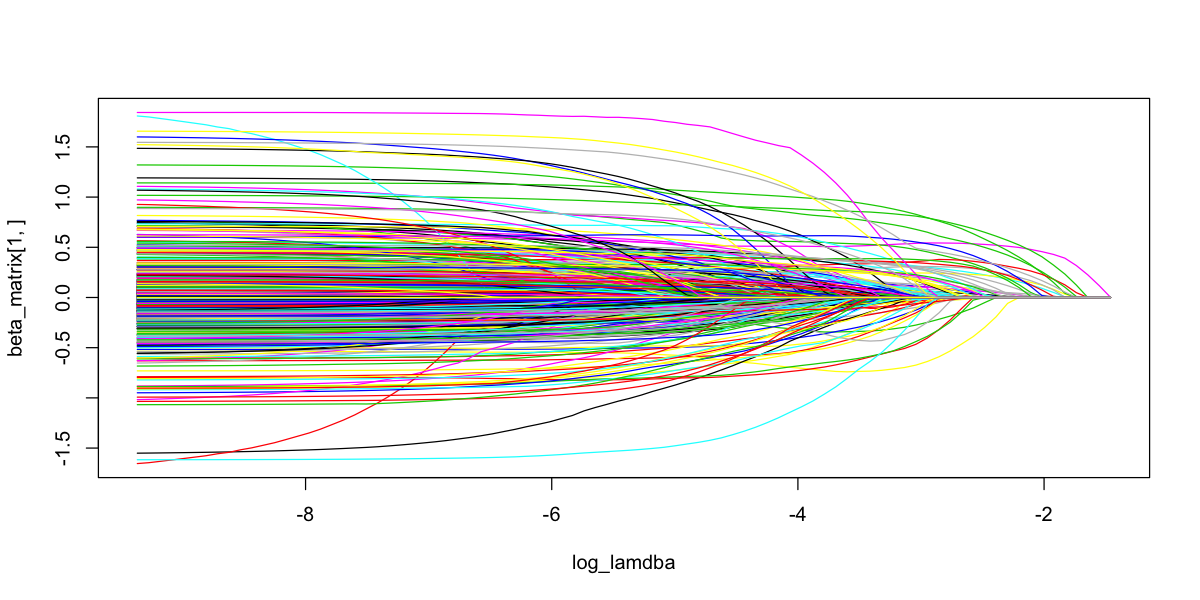

In [30]:
#Plot coefficient paths

#First, pull the lambda values used from the lasso regression object and log transform them
log_lamdba <- log(spender$lambda)

#Second, pull the coefficient matrix from the lasso regression object
beta_matrix <- as.matrix(spender$beta)

#Third, pull the number of coefficients which is the number of rows of the beta_matrix
num_coefs <- nrow(beta_matrix)

##Construct plot
#Plot first coefficient and establish plot
plot(x = log_lamdba,y = beta_matrix[1,],type="l",col=100,
     ylim=c(min(beta_matrix),max(beta_matrix))
    )
#Plot each additional coefficient
for(i in 2:num_coefs){
  points(log_lamdba,beta_matrix[i,],type="l",col=i)
}

#To run a stepwise regression plot, need to use gamlr package. Run this in R
stepspend <- gamlr(xweb, log(yspend), verb=TRUE, gamma=Inf, lmr=.1)

#Plot coefficient path
plot(stepspend, df=FALSE, select=FALSE) ## path plot

In [31]:
#View coefficients of spender regression selected under the AIC criteria
B <- as.matrix(coef(spender))

## a few examples
B <- B[-1,] # drop intercept and remove STM formatting
B[which.min(B)] ## low spenders spend a lot of time here
B[which.max(B)] ## big spenders hang out here

[1] -1.654149

[1] 1.843082

### Perform lasso regression with cross validation.

In [32]:
#Perfom the cross validation with cv.glmnet
cv.spender <- cv.glmnet(xweb, log(yspend),
                        nfolds = 5 #specify number of cross validation folds
                       )

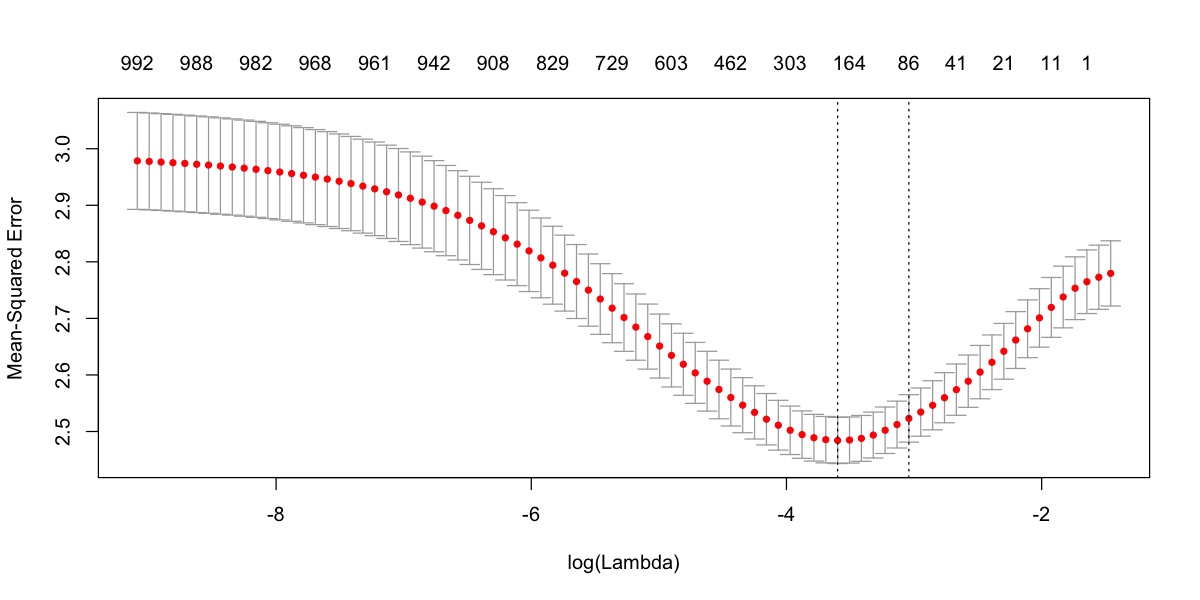

In [33]:
#Plot the coefficient confidence intervals
plot(cv.spender)

In [34]:
##Coeffcients under different lambdas (answers may differ from gamlr since different optimization)
#CV-1se rule
beta1se <- as.matrix(cv.spender$glmnet.fit$beta)[c("tvguide.com","americanexpress.com"),which(cv.spender$lambda == cv.spender$lambda.1se)]
#CV-min rule
betamin <- as.matrix(cv.spender$glmnet.fit$beta)[c("tvguide.com","americanexpress.com"),which(cv.spender$lambda == cv.spender$lambda.min)]
#Both viewed together
cbind(beta1se,betamin)[c("tvguide.com","americanexpress.com"),]

,beta1se,betamin
tvguide.com,0.00000000,0.0000000
americanexpress.com,0.03876544,0.0494034


### Return to regularization_model_specification rscript file for use of gamlr function with data and plots that match textbook.